# Agentes en LangGraph con Gemini


## Caso 5 Orquestados

<img src="https://langchain-ai.github.io/langgraph/tutorials/workflows/img/worker.png" alt="gate" width="600"/>

Con el patrón orquestador-trabajador, un orquestador descompone una tarea y delega cada sub-tarea a trabajadores. Como se menciona en el blog de Anthropic sobre la construcción de agentes efectivos:

En el flujo de trabajo orquestador-trabajadores, un LLM central descompone dinámicamente las tareas, las delega a LLMs trabajadores y sintetiza sus resultados.

Cuándo usar este flujo de trabajo: Este flujo es adecuado para tareas complejas donde no se pueden predecir las sub-tareas necesarias (por ejemplo, en programación, la cantidad de archivos que deben cambiarse y la naturaleza de cada cambio probablemente dependa de la tarea). Aunque es topográficamente similar a la paralelización, la diferencia clave es su flexibilidad: las sub-tareas no están predefinidas, sino que son determinadas por el orquestador según la entrada específica.


In [49]:
from typing import Annotated, List
import operator
from langgraph.types import Send
from pydantic import BaseModel, Field
from typing_extensions import TypedDict
from langgraph.graph import StateGraph, START, END
from IPython.display import Image, display
from langchain_core.messages import HumanMessage, SystemMessage


In [50]:
import os
import getpass
from langchain_google_genai import ChatGoogleGenerativeAI

# Declaración y llamado de la key del modelo LLM
# use esta función para definir la key del modelo LLM si tuvo problemas con el archivo .env.json o create_env.py
def _set_env(var: str):
   if not os.environ.get(var):
       os.environ[var] = getpass.getpass(f"{var}: ")

_set_env("GOOGLE_API_KEY")

llm = ChatGoogleGenerativeAI(model="gemini-1.5-pro")

Primero definimos el esquema para salida estructurada a usar en la planificación:


In [51]:
class Section(BaseModel):
    name: str = Field(
        description="Nombre para esta sección del informe.",
    )
    description: str = Field(
        description="Breve descripción de los temas y conceptos principales que se cubrirán en esta sección.",
    )


Definición del modelo Sections para estructurar la salida del planificador. Incluye una lista de secciones, cada una representando una parte del informe.

In [52]:
class Sections(BaseModel):
    sections: List[Section] = Field(
        description="Secciones del informe.",  # Descripción 
    )

Ahora Aumentamos el LLM con un esquema para salida estructurada usando el modelo `Sections`. Esto permite que el modelo genere una respuesta estructurada según el esquema definido en `Sections`.

In [53]:
planner = llm.with_structured_output(Sections)  # El planificador ahora devolverá secciones del informe en formato estructurado.

### Creando Workers en LangGraph

Debido a que los flujos de trabajo de orquestador-trabajador son comunes, LangGraph tiene la API Send para soportar esto. Permite crear dinámicamente nodos worker y enviar a cada uno una entrada específica. Cada worker tiene su propio estado, y todas las salidas de los workers se escriben en una clave de estado compartida que es accesible para el grafo del orquestador. Esto le da al orquestador acceso a todas las salidas de los workers y le permite sintetizarlas en una salida final. Como puedes ver abajo, iteramos sobre una lista de secciones y enviamos cada una a un nodo worker. Consulta la documentación adicional aquí y aquí.

In [54]:
# Estado del grafo
class State(TypedDict):
    topic: str  # Tema del informe
    sections: list[Section]  # Lista de secciones del informe
    completed_sections: Annotated[
        list, operator.add
    ]  # Todas las workers escriben en esta clave en paralelo
    final_report: str  # Informe final


En la siguiente celda se define la estructura y lógica del orquestador en el flujo de trabajo de generación de informes. Primero, se declara el estado que manejará cada worker (`WorkerState`), el cual contiene la sección específica que debe procesar cada worker y una lista acumulativa de secciones completadas, permitiendo la ejecución paralela y la agregación de resultados.

Luego, se implementa la función `orchestrator`, que actúa como el nodo orquestador del grafo. Esta función toma el estado global, utiliza el planificador (basado en un modelo de lenguaje) para generar un plan estructurado del informe a partir del tema proporcionado, y devuelve las secciones generadas en un formato estructurado. 

El orquestador es responsable de descomponer el problema principal (elaborar el informe) en sub-tareas (secciones), que luego serán distribuidas a los workers para su desarrollo individual.


In [ ]:

# Estado del worker (Worker state)
class WorkerState(TypedDict):
    section: Section  # Sección que el worker debe procesar
    completed_sections: Annotated[list, operator.add]  # Lista acumulada de secciones completadas por los workers

# Nodos (Nodes)
def orchestrator(state: State):
    """Orquestador que genera un plan para el informe"""

    # Generar las secciones del informe usando el planificador
    report_sections = planner.invoke(
        [
            SystemMessage(content="Genera un plan para el informe."),  # Instrucción al modelo para crear el plan
            HumanMessage(content=f"Aquí está el tema del informe: {state['topic']}"),  # Proporciona el tema al modelo
        ]
    )

    # Devuelve las secciones generadas en formato estructurado
    return {"sections": report_sections.sections}

SE define la funcion `llm_call` que representa el nodo worker encargado de redactar una sección individual del informe. Recibe el estado específico del worker, que contiene la sección a desarrollar y la lista acumulada de secciones completadas. Utiliza un modelo de lenguaje (LLM) para generar el contenido de la sección, proporcionando como contexto el nombre y la descripción de la sección. La instrucción al modelo especifica que debe escribir la sección en formato markdown, sin incluir preámbulos. El resultado generado por el modelo se agrega a la lista de secciones completadas, que será utilizada posteriormente para sintetizar el informe completo.

In [ ]:

def llm_call(state: WorkerState):
    """Worker que escribe una sección del informe"""

    # Generar la sección del informe utilizando el modelo de lenguaje
    section = llm.invoke(
        [
            SystemMessage(
                content="Escribe una sección del informe siguiendo el nombre y la descripción proporcionados. No incluyas ningún preámbulo para cada sección. Utiliza formato markdown."
            ),
            HumanMessage(
                content=f"Aquí está el nombre de la sección: {state['section'].name} y la descripción: {state['section'].description}"
            ),
        ]
    )

    # Escribir la sección generada en la lista de secciones completadas
    return {"completed_sections": [section.content]}

En la siguiente celda define dos funciones clave para el flujo de trabajo del orquestador:

1. `synthesizer(state: State)`: Esta función toma el estado actual, que contiene una lista de secciones del informe ya completadas (`completed_sections`). Su propósito es sintetizar el informe final uniendo todas las secciones en una sola cadena de texto, separadas por delimitadores (`\n\n---\n\n`). El resultado se devuelve en un diccionario bajo la clave `"final_report"`, listo para ser utilizado o presentado como el informe completo.

2. `assign_workers(state: State)`: Esta función es utilizada como función condicional de borde en el grafo de estados. Recibe el estado actual, accede a la lista de secciones planificadas (`state["sections"]`) y para cada sección crea una instrucción para enviar el trabajo al nodo `"llm_call"`, pasando la sección correspondiente. Esto permite que cada sección del informe sea redactada en paralelo por un worker independiente.


In [ ]:
def synthesizer(state: State):
    """Sintetiza el informe completo a partir de las secciones"""

    # Lista de secciones completadas
    completed_sections = state["completed_sections"]

    # Formatea las secciones completadas como una sola cadena, separadas por delimitadores, para usarlas como contexto en las secciones finales
    completed_report_sections = "\n\n---\n\n".join(completed_sections)

    # Devuelve el informe final como un solo string
    return {"final_report": completed_report_sections}


# Función condicional de borde para crear workers llm_call que escriben cada sección del informe
def assign_workers(state: State):
    """Asigna un worker a cada sección en el plan"""

    # Inicia la escritura de secciones en paralelo usando la API Send()
    return [Send("llm_call", {"section": s}) for s in state["sections"]]

Construimos el workflow

In [64]:
orchestrator_worker_builder = StateGraph(State)

Ahora definimos los nodos:

In [59]:
orchestrator_worker_builder.add_node("orchestrator", orchestrator)
orchestrator_worker_builder.add_node("llm_call", llm_call)
orchestrator_worker_builder.add_node("synthesizer", synthesizer)


Y las aristas:

In [60]:
orchestrator_worker_builder.add_edge(START, "orchestrator")
orchestrator_worker_builder.add_conditional_edges(
    "orchestrator", assign_workers, ["llm_call"]
)
orchestrator_worker_builder.add_edge("llm_call", "synthesizer")
orchestrator_worker_builder.add_edge("synthesizer", END)

Ya podemos compilar el grafo:

In [61]:
orchestrator_worker = orchestrator_worker_builder.compile()

Lo visualizamos:

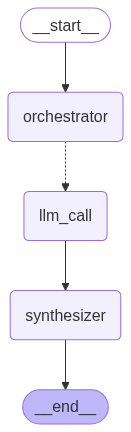

In [62]:
display(Image(orchestrator_worker.get_graph().draw_mermaid_png()))


Y finalmente hacemos una prueba de invocación del grafo:

In [63]:
# Invocación
state = orchestrator_worker.invoke({"topic": "Crea un informe sobre las leyes de escalado de los LLM"})

from IPython.display import Markdown
Markdown(state["final_report"])


# Introducción a los LLM

Los Modelos Lingüísticos Grandes (LLM) son un tipo de modelo de inteligencia artificial (IA) entrenado en grandes cantidades de datos de texto. Pueden realizar una variedad de tareas relacionadas con el lenguaje, como:

* **Generación de texto:** Los LLM pueden generar texto similar al humano en una variedad de estilos, como poemas, código, guiones, piezas musicales, correo electrónico, cartas, etc. También pueden traducir entre idiomas y resumir texto.
* **Comprensión del lenguaje:** Los LLM pueden comprender el texto escrito, incluida la identificación del tema principal, encontrar información específica y responder preguntas.
* **Diálogo:** Los LLM pueden conversar con los humanos de forma natural, respondiendo preguntas y haciendo preguntas relevantes.

Los LLM se basan típicamente en arquitecturas de aprendizaje profundo, como las redes neuronales transformadoras. Estas arquitecturas permiten que los LLM aprendan los patrones y las estructuras del lenguaje, lo que les permite generar y comprender texto similar al humano. El tamaño de los LLM puede variar desde unos pocos millones hasta cientos de miles de millones de parámetros. En general, los modelos más grandes tienden a funcionar mejor, pero también requieren más recursos computacionales para entrenar y usar.

Los LLM tienen el potencial de revolucionar la forma en que interactuamos con las computadoras. Pueden facilitar tareas como escribir, investigar y comunicarse con otros. Sin embargo, también es importante tener en cuenta los riesgos potenciales asociados con los LLM, como la posibilidad de que se utilicen para generar información errónea o propaganda.

---

## Leyes de escalado para los LLM

El rendimiento de los grandes modelos lingüísticos (LLM) está intrínsecamente ligado al tamaño del modelo, el tamaño del conjunto de datos y la potencia de cálculo utilizada durante el entrenamiento. La relación entre estos factores a menudo se rige por las leyes de escalado, que proporcionan información sobre cómo mejora el rendimiento al escalar los recursos.

Las leyes de escalado normalmente muestran una relación de ley de potencia entre el rendimiento del modelo (medido por métricas como la pérdida o la precisión) y los recursos (tamaño del modelo, tamaño del conjunto de datos o cálculo). En otras palabras, aumentar los recursos normalmente conduce a una mejora del rendimiento, pero con rendimientos decrecientes.

**Tamaño del modelo:** Aumentar el número de parámetros en un LLM generalmente conduce a un mejor rendimiento en diversas tareas. Sin embargo, la relación entre el tamaño del modelo y el rendimiento no es lineal. Después de cierto punto, aumentar aún más el tamaño del modelo produce mejoras de rendimiento marginalmente más pequeñas. Se han propuesto varias leyes de escalado para capturar esta relación, a menudo indicando una ley de potencia con un exponente decreciente.

**Tamaño del conjunto de datos:** De manera similar al tamaño del modelo, escalar el tamaño del conjunto de datos de entrenamiento también mejora el rendimiento. Un conjunto de datos más grande expone al modelo a una mayor diversidad de lenguaje y patrones, lo que lleva a una mejor generalización. Sin embargo, las ganancias de rendimiento disminuyen a medida que aumenta el tamaño del conjunto de datos, lo que sugiere que existe un límite en la cantidad de datos que un modelo puede utilizar de manera efectiva.

**Potencia de cálculo:** La potencia de cálculo juega un papel crucial en el entrenamiento de los LLM. Una mayor potencia de cálculo permite entrenar modelos más grandes en conjuntos de datos más grandes durante más tiempo. La relación entre la potencia de cálculo y el rendimiento también sigue una ley de escalado, pero la tasa de mejora puede variar según el modelo y la arquitectura de entrenamiento específicos.

Comprender estas leyes de escalado es esencial para el desarrollo eficiente de LLM. Al cuantificar la relación entre los recursos y el rendimiento, los investigadores pueden tomar decisiones informadas sobre cómo asignar los recursos de manera óptima para lograr las mejoras de rendimiento deseadas. Además, las leyes de escalado pueden ayudar a predecir el rendimiento de los modelos futuros y guiar la investigación en el desarrollo de arquitecturas de modelos más eficientes.

---

### Implicaciones de las leyes de escalado

Las leyes de escalado han surgido como un principio rector crucial en el desarrollo de modelos de lenguaje grande (LLM). Describen la relación predecible entre el tamaño del modelo (número de parámetros), los datos de entrenamiento y el rendimiento computacional. En esencia, las leyes de escalado sugieren que aumentar el tamaño del modelo y los datos de entrenamiento, junto con una potencia de cálculo proporcional, conduce a una mejora continua del rendimiento del modelo. Esta observación ha tenido profundas implicaciones para la investigación y desarrollo de LLM, dando forma a las estrategias de investigación y generando expectativas sobre el futuro de estos modelos.

Una de las implicaciones más significativas de las leyes de escalado es el impulso hacia modelos aún más grandes. A medida que la investigación inicial demostró una fuerte correlación entre el tamaño del modelo y el rendimiento, hubo una tendencia a entrenar modelos cada vez más grandes. Esta tendencia ha dado lugar a una serie de LLM con miles de millones, e incluso billones, de parámetros, lo que ha logrado resultados notables en diversas tareas de PNL. Sin embargo, el simple escalado también trae consigo desafíos, incluido el creciente costo computacional y la huella ambiental del entrenamiento de estos modelos masivos.

Además, las leyes de escalado han resaltado la importancia de los datos de entrenamiento. A medida que aumenta el tamaño de los modelos, también aumenta su apetito por los datos. Esto ha llevado a los investigadores a explorar nuevas formas de adquirir y curar conjuntos de datos masivos, lo que incluye técnicas novedosas para el filtrado y la limpieza de datos. La calidad de los datos de entrenamiento se ha vuelto cada vez más crítica, ya que los modelos más grandes son susceptibles de aprender y amplificar los sesgos presentes en los datos, lo que genera preocupaciones éticas y prácticas.

Otra implicación de las leyes de escalado es la necesidad de arquitecturas de modelos más eficientes. A medida que el escalado ingenuo se vuelve prohibitivamente costoso, los investigadores están explorando activamente nuevas arquitecturas y técnicas de entrenamiento que pueden lograr un rendimiento similar con menores requisitos computacionales. Esto incluye explorar arquitecturas de modelos dispersos, técnicas de aprendizaje por transferencia y otras innovaciones destinadas a mejorar la eficiencia del entrenamiento y la inferencia.

Por último, las leyes de escalado han suscitado importantes cuestiones sobre los límites del escalado. Si bien las tendencias iniciales sugirieron una mejora continua con el tamaño, no está claro si estas leyes se mantendrán indefinidamente. Hay preguntas abiertas sobre si hay un punto de rendimientos decrecientes o si surgirán limitaciones fundamentales. La investigación futura deberá explorar estos límites y determinar si existen límites inherentes a la escalabilidad de los LLM.

En resumen, las leyes de escalado han tenido una profunda influencia en la trayectoria de la investigación y desarrollo de los LLM. Han impulsado la tendencia hacia modelos más grandes, han destacado la importancia de los datos, han motivado la investigación en arquitecturas de modelos eficientes y han planteado preguntas fundamentales sobre los límites del escalado. A medida que el campo continúa evolucionando, comprender y abordar las implicaciones de las leyes de escalado seguirá siendo crucial para el desarrollo de LLM más capaces y sostenibles.

---

## Conclusión

Este informe ha examinado [tema del informe]. Nuestros hallazgos indican que [hallazgo clave 1] y que [hallazgo clave 2]. Además, hemos descubierto que [hallazgo clave 3].

Estos hallazgos tienen varias implicaciones. En primer lugar, sugieren que [implicación 1]. En segundo lugar, apuntan hacia la necesidad de [implicación 2]. Por último, plantean interrogantes sobre [implicación 3].

Se justifican futuras investigaciones para abordar varias cuestiones sin resolver. En primer lugar, sería útil investigar [dirección futura de la investigación 1]. Además, sería informativo explorar [dirección futura de la investigación 2]. Por último, un estudio sobre [dirección futura de la investigación 3] podría arrojar luz sobre [cuestión sin resolver].